Notebook to implement mask augmentation based on low frequencies




In [1]:
#ico class
import os
import numpy as np
import nibabel as nb
import copy
from scipy import sparse 
import meld_classifier.mesh_tools as mt
import torch
from math import pi 
import logging
from meld_graph.icospheres import IcoSpheres
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
import matplotlib_surface_plotting as msp
from scipy.stats import special_ortho_group
from scipy.spatial import cKDTree
# import logging
# logging.basicConfig(level=logging.DEBUG)

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 


In [2]:
#initialise cohort
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')

# initialise icospheres
icos=IcoSpheres(conv_type='SpiralConv')
# Select icosphere
ico_index=7
ico_ini = icos.icospheres[ico_index]

# initialise inflated brain
coords = cohort.surf["coords"]
faces = cohort.surf["faces"]

In [13]:
# load lesion for a patient

subject = 'MELD_H9_3T_FCD_0007'
s = MeldSubject(subject,cohort=cohort)

hemi = s.get_lesion_hemisphere()

dists, labels = s.load_feature_lesion_data(
            features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
        )

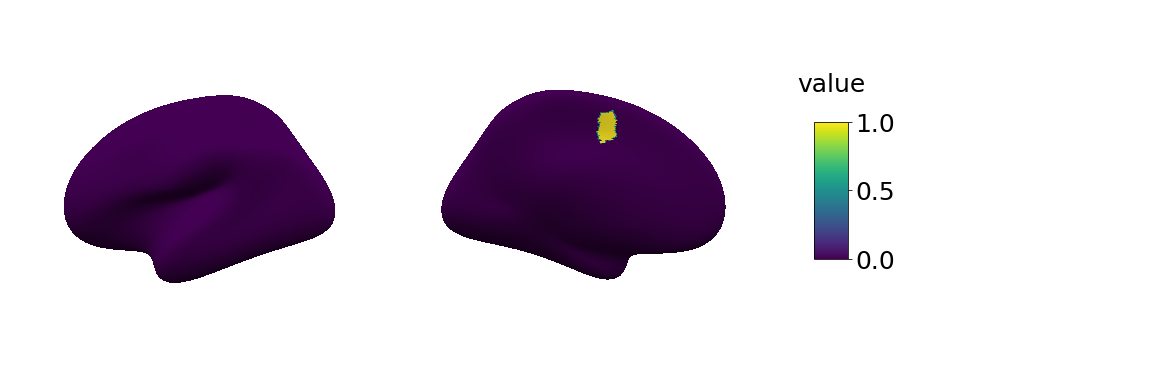

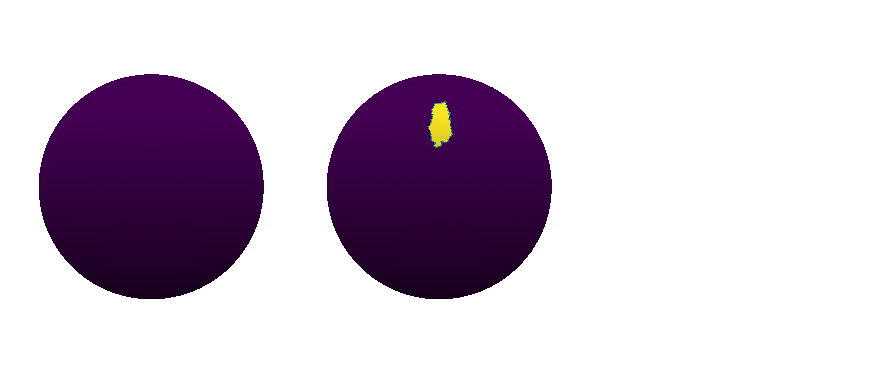

In [14]:
# plot lesion before augmentation

overlay=labels
msp.plot_surf(coords,faces, 
                overlay,
                flat_map=False,
                rotate=[90, 270],
             )


msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              overlay,
              colorbar=False,
            #   rotate=[80],z_rotate=-70,
                 )

In [12]:
# # function to augment mask - IMPLEMENTATION

# import potpourri3d as pp3d
# from meld_graph.models import HexUnpool, HexPool
# from meld_graph.data_preprocessing import Preprocess

# def unpool(level=7):
#     num = len(icos.get_neighbours(level=level))
#     upsample = icos.get_upsample(target_level=level)
#     unpooling = HexUnpool(upsample_indices=upsample, target_size=num)
#     return unpooling

# solver = pp3d.MeshHeatMethodDistanceSolver(coords,faces)
# n_vert = len(coords)
# indices = np.arange(n_vert,dtype=int)
# ico_low_index=2
# ico_low = icos.icospheres[ico_low_index]
# n_vert_low = len(ico_low['coords'])
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# def augment_mask(mask, noise_std=0.5):

#     # get geodesic distance (negative inside lesion, positive outside)
#     new_dist = proc.fast_geodesics(mask)

#     # normalise by minimum values
#     new_dist_norm = new_dist / np.abs(new_dist.min())

#     # create low frequencies noise on low res icosphere
#     noise = np.random.normal(0,noise_std,n_vert_low)

#     #upsample noise to high res
#     for level in range(ico_low_index, 7):
#         unpool_ind = unpool(level=level+1)
#         noise_upsampled = unpool_ind(torch.from_numpy(noise.reshape(-1,1)), device = device)
#         noise_upsampled = noise_upsampled.detach().cpu().numpy().ravel()
#         noise = noise_upsampled.copy()
    
#     #add noise to distance normalised
#     new_mask = (new_dist_norm + noise_upsampled)<=0

#     return new_mask
    

In [15]:
# # test upsampling noise to see in interpolation 

# noise = np.random.randint(2,size=n_vert_low).astype(float)
# print(set(noise))
# for level in range(ico_low_index, 7):
#     unpool_ind = unpool(level=level+1)
#     noise_upsampled = unpool_ind(torch.from_numpy(noise.reshape(-1,1)), device = device)
#     noise_upsampled = noise_upsampled.detach().cpu().numpy().ravel()
#     noise = noise_upsampled.copy()
# print(set(noise_upsampled))

In [15]:
import time

from meld_graph.data_preprocessing import Preprocess

proc = Preprocess(cohort, icospheres=icos)
proc.setup_distance_solver()

mask_augmented_array=[]
size_augmented_1 = []
size_augmented_05 = []
for i in range(0,50):
    start_time = time.time()
    mask_augmented_05 = proc.augment_lesion(labels, noise_std=0.5)
    mask_augmented_1 = proc.augment_lesion(labels, noise_std=1)
    mask_augmented_array.append(mask_augmented_05)
    # print("My program took", time.time() - start_time, "to run")
    size_augmented_1.append(mask_augmented_1.sum())
    size_augmented_05.append(mask_augmented_05.sum())
    

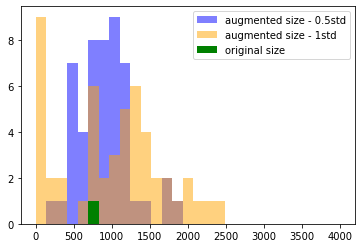

In [17]:
# look at size of augmented lesions

import matplotlib.pyplot as plt
bins = np.linspace(0, 4000, 30)
plt.hist(size_augmented_05, color='blue', bins=bins, alpha=0.5, label='augmented size - 0.5std')
plt.hist(size_augmented_1, color='orange', bins=bins, alpha=0.5, label='augmented size - 1std')
plt.hist([labels.sum()], color='green', bins=bins, label='original size')
plt.legend()

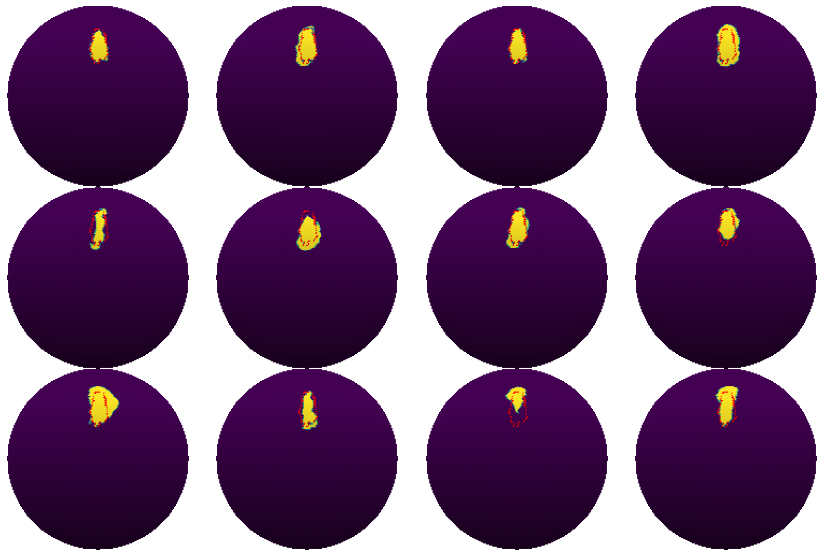

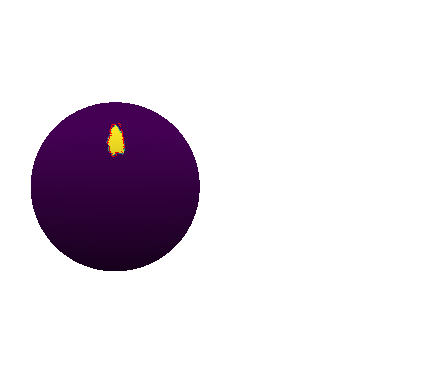

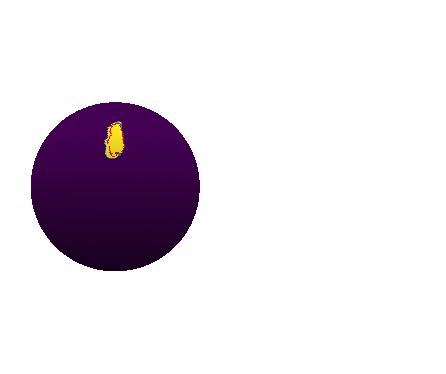

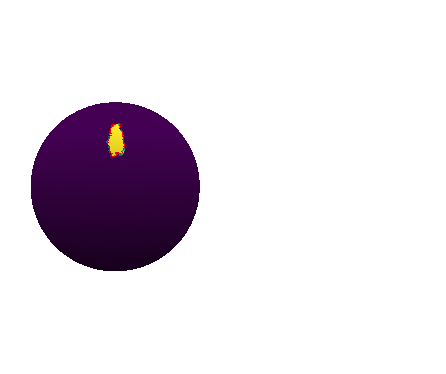

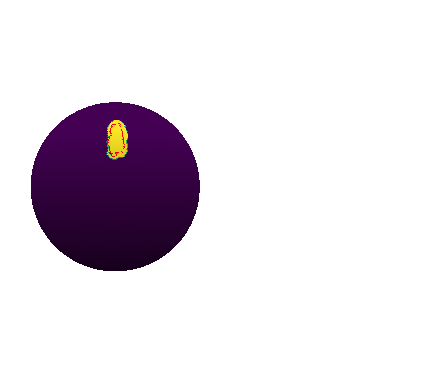

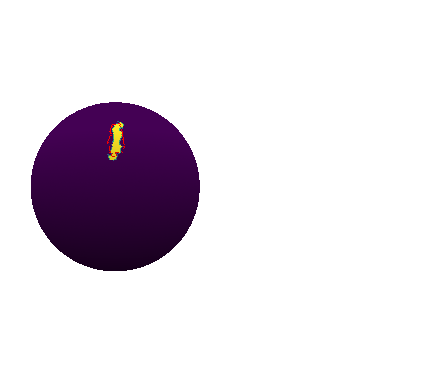

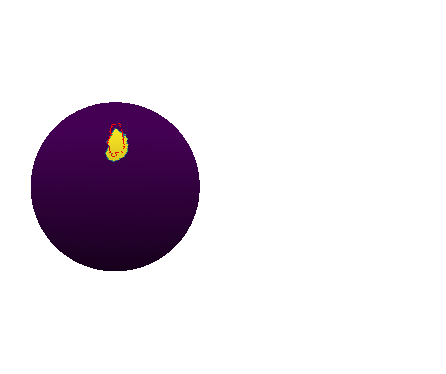

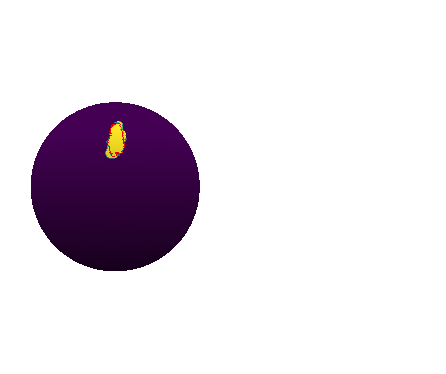

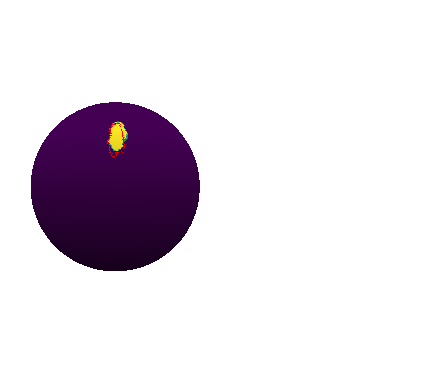

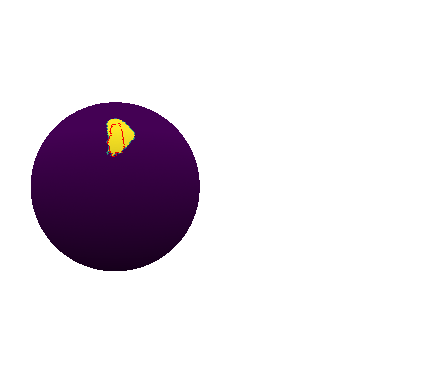

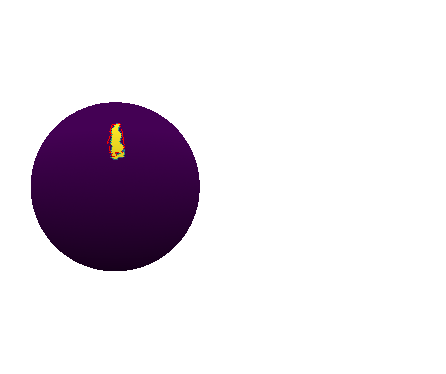

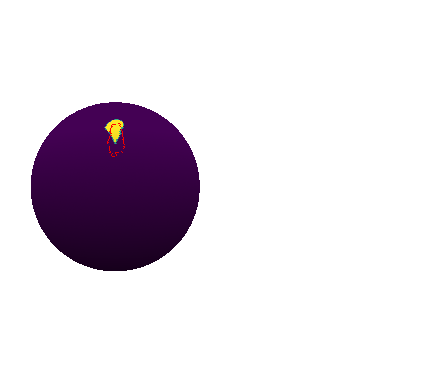

In [19]:
# plot lesion after augmentation
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def create_surface_plots(coords,faces,overlay,flat_map=True, parcel = None):
    """plot and reload surface images"""
    from meld_classifier.meld_plotting import trim
    import matplotlib_surface_plotting.matplotlib_surface_plotting as msp
    from PIL import Image
    import numpy as np
    parcel_cmap = {1:[1,0,0,0]}
    msp.plot_surf(coords,faces, 
                overlay,
                flat_map=flat_map,
                parcel = parcel, 
                parcel_cmap = parcel_cmap,
                rotate=[270],
                # rotate=[100],z_rotate=-70,
                show_back=True,
                filename='tmp.png',
                colorbar=False,
             )
    im = Image.open('tmp.png')
    im = trim(im)
    im = im.convert("RGBA")
    im1 = np.array(im)
    return im1

fig= plt.figure(figsize=(15,10), constrained_layout=True)
gs1 = GridSpec(3, 4,  wspace=0, hspace=0)

for i, overlay in enumerate(mask_augmented_array[0:12]):
    ax = fig.add_subplot(gs1[i])
    im = create_surface_plots(ico_ini['coords'],ico_ini['faces'],overlay,flat_map=False, parcel=labels)
    ax.imshow(im)
    ax.axis('off')
    
plt.close()

## Implementation

In [11]:
import torch.nn as nn
from meld_graph.models import HexUnpool, HexPool

class HexSmooth(nn.Module):
    def __init__(self, neighbours):
        super(HexSmooth, self).__init__()
        self.neighbours = neighbours
        
    def forward(self, x, device):
        x = torch.from_numpy(x.astype(float)).to(device)
        new_x = torch.mean(x[self.neighbours],dim=1)
        return new_x
        
def pool(level=7):
        neigh_indices = icos.get_downsample(target_level=level)

        pooling = HexPool(neigh_indices=neigh_indices)
        return pooling
        
def unpool(level=7):
    num = len(icos.get_neighbours(level=level))
    upsample = icos.get_upsample(target_level=level)
    unpooling = HexUnpool(upsample_indices=upsample, target_size=num)
    return unpooling

def fast_geodesics(lesion):
        """calculate geodesic distances on downsampled mesh then upsample
        currently calculating on level 5, with two upsample steps"""

        #downsample lesion
        #if no lesion, no distance
        if lesion.sum()==0:
            n_vert = len(icos.icospheres[7]['coords'])
            return np.ones(n_vert)*200
        n_vert = len(icos.icospheres[5]['coords'])

        #downsample mask
        indices = np.arange(n_vert,dtype=int)
        downsampled1 = pool7(torch.from_numpy(lesion.reshape(-1,1)))
        lesion_small = pool6(downsampled1).detach().cpu().numpy().ravel()
        
        #find boundaries
        neighbours = icos.get_neighbours(level=5)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        smooth5 = HexSmooth(neighbours=neighbours)
        new_lesion = smooth5(lesion_small, device)
        new_lesion = new_lesion.detach().cpu().numpy().ravel()
        lesion_boundary_vertices = indices[(lesion_small - new_lesion)>0]
        boundary_distance = solver.compute_distance_multisource(lesion_boundary_vertices)

        #upsample distance
        upsampled1 = unpool6(torch.from_numpy(boundary_distance.reshape(-1,1)),device=device)
        full_upsampled = unpool7(upsampled1, device = device)
        full_upsampled = full_upsampled.detach().cpu().numpy().ravel()
        full_upsampled[lesion>0]=-full_upsampled[lesion>0]
        
        return full_upsampled

In [28]:
# # from meld_graph.models import HexSmooth
# import torch.nn as nn
# from meld_graph.models import HexUnpool, HexPool
# class HexSmooth(nn.Module):
#     def __init__(self, neighbours):
#         super(HexSmooth, self).__init__()
#         self.neighbours = neighbours
        
#     def forward(self, x, device):
#         x = torch.from_numpy(x.astype(float)).to(device)
#         new_x = torch.mean(x[self.neighbours],dim=1)
#         return new_x

# neighbours = icos.get_neighbours(level=5)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# smooth5 = HexSmooth(neighbours=neighbours)

# pool6=pool(5)
# pool7=pool(6)
# n_vert = len(icos.icospheres[5]['coords'])
# indices = np.arange(n_vert,dtype=int)
# downsampled1 = pool7(torch.from_numpy(labels.reshape(-1,1)))
# lesion_small = pool6(downsampled1).detach().cpu().numpy().ravel()
# new_lesion = smooth5(lesion_small, device)
# new_lesion = new_lesion.detach().cpu().numpy().ravel()
# boundaries = (lesion_small - new_lesion)>0


In [12]:
# get geodesic distance (negative inside lesion, positive outside)
import potpourri3d as pp3d
import time
# solver = pp3d.MeshHeatMethodDistanceSolver(coords,faces)
# n_vert = len(coords)
# indices = np.arange(n_vert,dtype=int)

# # define functions
# def flatten(t):
#     return [item for sublist in t for item in sublist]

pool6=pool(5)
pool7=pool(6)
unpool6=unpool(6)
unpool7=unpool(7)
solver = pp3d.MeshHeatMethodDistanceSolver(icos.icospheres[5]['coords'],
                       icos.icospheres[5]['faces'])

start_time = time.time()
# non_lesion_and_neighbours=flatten(np.array(cohort.neighbours)[labels==0])
# lesion_boundary_vertices=np.setdiff1d(non_lesion_and_neighbours,np.where(labels==0)[0])

# new_dist = solver.compute_distance_multisource(lesion_boundary_vertices)
# new_dist[labels>0]=-new_dist[labels>0]

new_dist = fast_geodesics(labels)
print("My program took", time.time() - start_time, "to run")


My program took 0.015050649642944336 to run


In [13]:
# normalise by minimum values

new_dist_norm = new_dist / np.abs(new_dist.min())

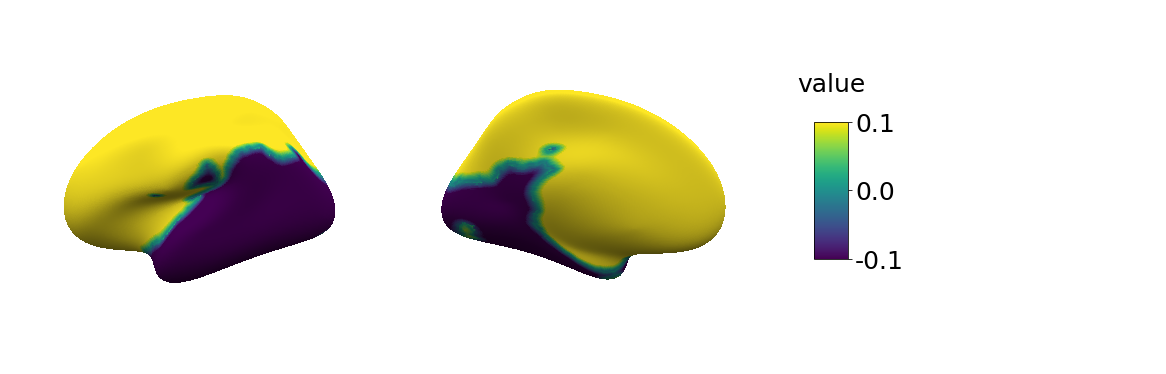

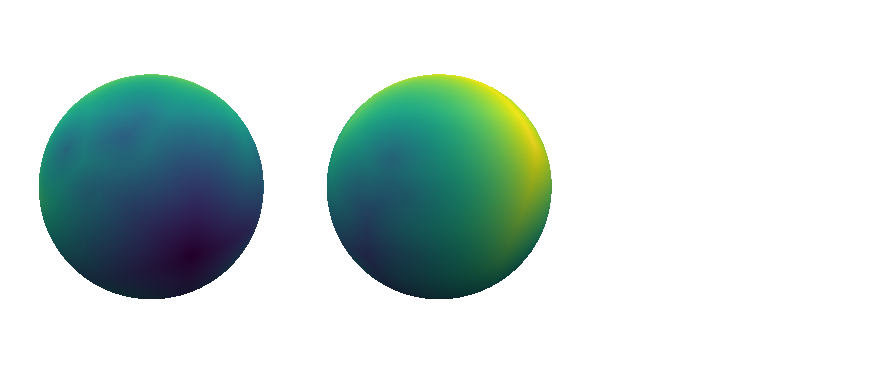

In [14]:
# plot new distance normed

overlay=new_dist_norm
msp.plot_surf(coords,faces, 
                overlay,
                flat_map=False,
                rotate=[90, 270],
               #  vmin=-0.1, vmax=0.1,
             )


msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              overlay,
              colorbar=False
                 )

162


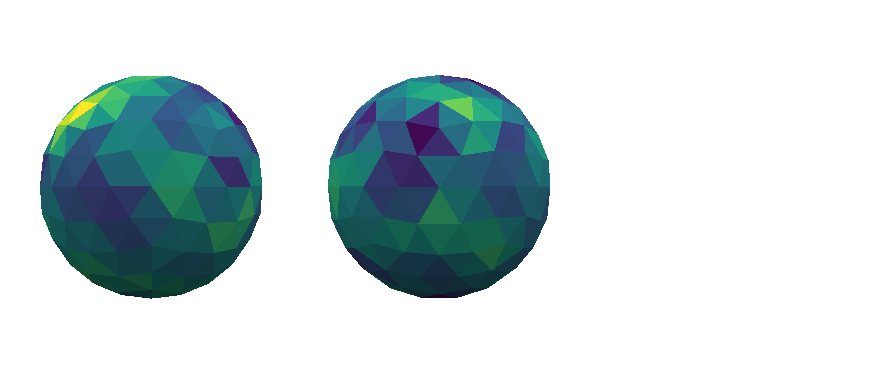

In [35]:
# create low frequencies noise and add to boundaries

# Select low res icosphere
ico_low_index=2
ico_low = icos.icospheres[ico_low_index]
n_vert_low = len(ico_low['coords'])
print(n_vert_low)

noise = np.random.normal(-0.5,0.5,n_vert_low)

#plot noise low res
msp.plot_surf(ico_low['coords'],
              ico_low['faces'],
              noise,
              colorbar=False
                 )


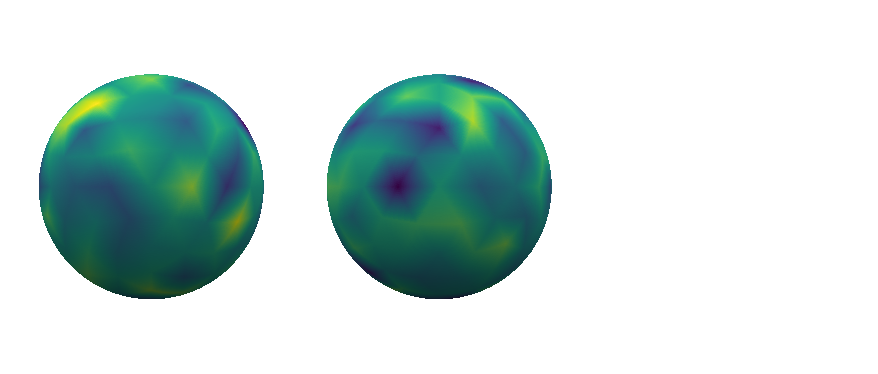

In [36]:
#upsample noise to high res
from meld_graph.models import HexUnpool, HexPool
def unpool(level=7):
    num = len(icos.get_neighbours(level=level))
    upsample = icos.get_upsample(target_level=level)
    unpooling = HexUnpool(upsample_indices=upsample, target_size=num)
    return unpooling
    

for level in range(ico_low_index, 7):
    unpool_ind = unpool(level=level+1)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    noise_upsampled = unpool_ind(torch.from_numpy(noise.reshape(-1,1)), device = device)
    noise_upsampled = noise_upsampled.detach().cpu().numpy().ravel()
    noise = noise_upsampled.copy()
    
#plot noise low res
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              noise_upsampled,
              colorbar=False
                 )

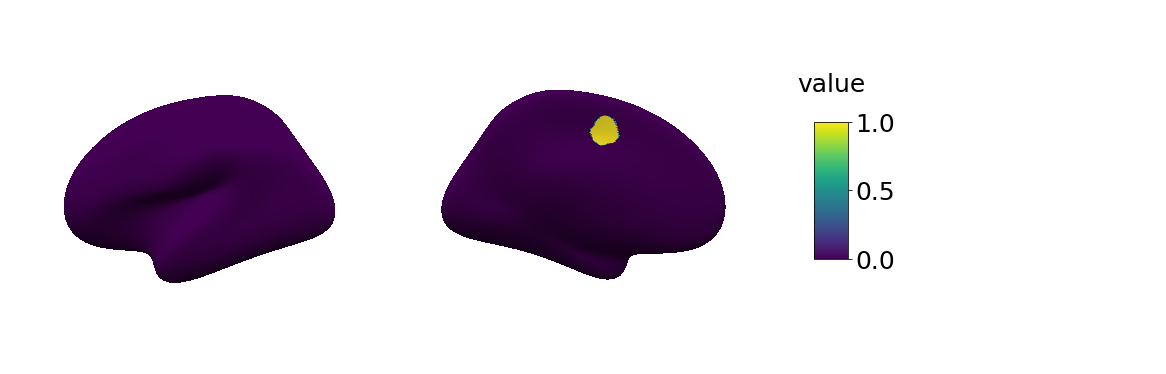

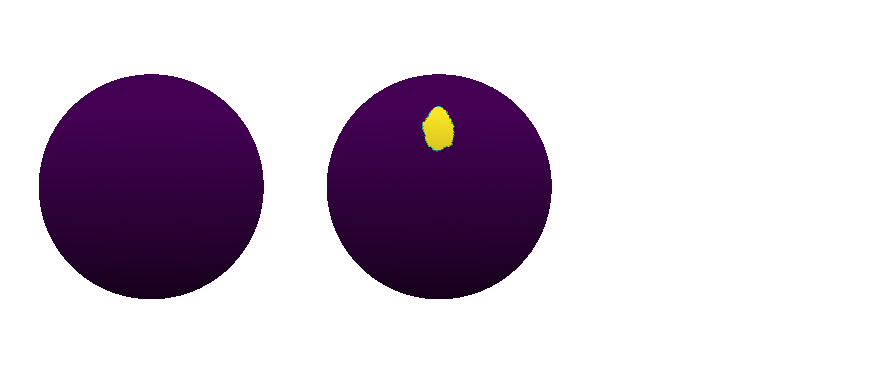

In [37]:
# add upsample noise to distance and threshold

new_labels = (new_dist_norm + noise_upsampled)<=0

overlay=new_labels
msp.plot_surf(coords,faces, 
                overlay,
                flat_map=False,
                rotate=[90, 270],
             )


msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              overlay,
              colorbar=False
                 )